# TEC analysis from GGNSS data

## データ読み込み

In [ ]:
import os, re, math; from gnss_tec import rnx;import matplotlib.pyplot as plt
from gnss_tec.glo import collect_freq_nums

data={} # データ格納用辞書（キーはファイル名を使う）
dir_path = "./data"  # データを展開したフォルダ
for path in os.listdir(dir_path):# データ読み込み
    file_name, ext = os.path.splitext(path)
    if ext == ".24o": # 観測データがあれば
        # 観測データ内の概略座標値を格納する
        f = open(dir_path+'/'+file_name+'.24o','r');lines = f.readlines()
        words=re.split(" +",lines[7])
        lat=math.asin(float(words[3])/6371000)*180.0/math.pi
        lon=math.atan2(float(words[2]),float(words[1]))*180.0/math.pi; f.close()
        # 対応する衛星軌道情報も読み込む
        glo_freq_nums=collect_freq_nums(dir_path+'/'+file_name+'.24q');tecs = {} # 観測データを読み込む辞書
        with open(dir_path+'/'+file_name+'.24o') as obs_file:
            reader = rnx(obs_file, glo_freq_nums=glo_freq_nums)
            for tec in reader:
                if not tec.satellite in tecs:
                    tecs[tec.satellite]=[]
                tecs[tec.satellite].append({
                    "timestamp":tec.timestamp,"phase_tec":tec.phase_tec,"p_range_tec":tec.p_range_tec})
        if 'J02' in tecs: # みちびき2号機('J02')の情報だけを格納する
            data[file_name]={'lon':lon,'lat':lat,'timestamp':[tec['timestamp'] for tec in tecs['J02']],
                'p_range_tec':[tec['p_range_tec'] for tec in tecs['J02']],
                'phase_tec':[tec['phase_tec'] for tec in tecs['J02']]}
            print(file_name)

## データ描画

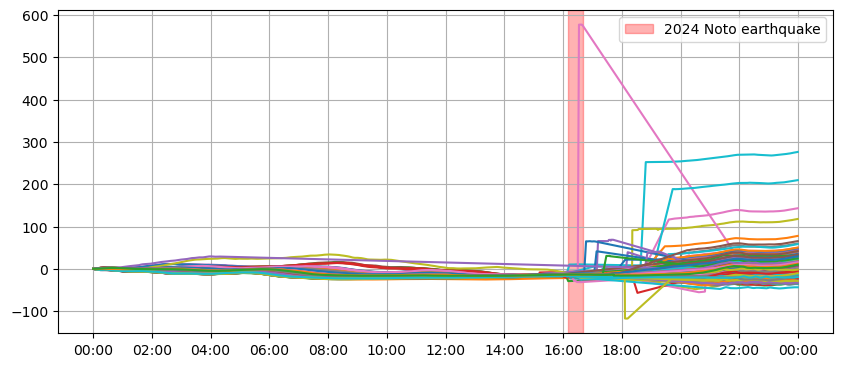

In [803]:
from datetime import datetime
from matplotlib.dates import date2num,HourLocator,DateFormatter

fig, ax = plt.subplots(figsize=[10,4.2])
for key in data.keys(): 　# keys -> 観測点ファイル名
    try:
        t=data[key]['timestamp']
        y=[v-data[key]['phase_tec'][0] for v in data[key]['phase_tec']];ax.plot(t, y)     
    except:
        pass
ax.xaxis.set_major_locator(HourLocator(byhour=range(0, 24, 2), tz=None))
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.axvspan(date2num(datetime(2024,1,1,16,10)),date2num(datetime(2024,1,1,16,40)), 
           label="2024 Noto earthquake",color="red", alpha=0.3)
#ax.set_xlim(date2num(datetime(2024,1,1,10,0)),date2num(datetime(2024,1,1,17,0)));ax.set_ylim(-50,100)
ax.grid(); ax.legend(); plt.show()

## 地図上に描く

In [ ]:
import numpy as np; from scipy import signal

def bandpass(x, samplerate, fp, fs, gpass, gstop):
    fn=samplerate/2.0;N,Wn=signal.buttord(fp/fn,fs/fn,gpass,gstop) #フィルタの伝達関数計算
    b,a=signal.butter(N,Wn,"band")              
    return signal.filtfilt(b,a,x)

samplerate=2 # point/min
low_f=0.05;high_f=0.25;gpass=10;gstop=40 # 周波数両端や、通過域端最大損失[dB]や阻止域端最小損失[dB]
fp = np.array([low_f, high_f])           # 通過域端周波数[Cycle/min]
fs = np.array([low_f/10.0, 10.0*high_f]) # 阻止域端周波数[Cycle/min]

In [ ]:
import datetime; import numpy as np; from scipy import signal
import matplotlib.pyplot as plt
import cartopy.crs as ccrs # conda install conda-forge::cartopy
import cartopy.feature as cfeature

def bandpass(x, samplerate, fp, fs, gpass, gstop):
    fn=samplerate/2.0;N,wn=signal.buttord(fp/fn,fs/fn,gpass,gstop);b,a=signal.butter(N,wn,"band")              
    return signal.filtfilt(b,a,x)

def make_lon_lat_mag(date_time):
    lon=[]; lat=[]; mag=[] # 緯度経度と電子数を格納する
    for key in data.keys(): # keys = 観測点ファイル名
        try: # 2024年（令和6年）1月1日16時13分　のデータを格納
            i = data[key]['timestamp'].index(date_time)
            y=[v-data[key]['phase_tec'][0] for v in data[key]['phase_tec']]
            y=bandpass(y,samplerate,fp,fs,gpass,gstop)
            y=np.vectorize(np.linalg.norm)(y);mag.append(y[i]) # 各要素の符号を＋にして格納
            lon.append(data[key]['lon']);lat.append(data[key]['lat']) # 緯度・経度も格納する
        except:
            pass
    return [lon,lat,mag]

def draw_map(date_time):
    lon,lat,mag=make_lon_lat_mag(date_time)
    fig = plt.figure(figsize=(12,12),facecolor='black')
    ax = plt.axes(projection=ccrs.Miller()) # ミラー図法
    ax.add_feature(cfeature.OCEAN);ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.LAKES);ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.BORDERS);ax.set_extent([125,145,25,45])
    ax.coastlines(resolution="110m",linewidth=1);
    ax.gridlines(linestyle='--',color='black')
    ax.scatter(lon,lat,c=mag,cmap=plt.get_cmap('jet'),
      transform=ccrs.PlateCarree(),alpha=0.4,s=300,linewidth=0,
      vmin=0.,vmax=0.5,label=date_time.strftime('%Y/%m/%d %H:%M:%S'));
    plt.legend();plt.show()

samplerate=2 # point/min
low_f=0.05;high_f=0.25;gpass=10;gstop=40 # 周波数両端や、通過域端最大・最小損失[dB]
fp=np.array([low_f,high_f]);fs=np.array([low_f/10.0,10.0*high_f]) # [Cycle/min]
for m in range(10,30,1):
    draw_map(datetime.datetime(2024, 1, 1, 16, m, 30))